In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
image_size = 224
batch_size = 32
test_size = 0.2 
channels = 3
epoch = 100

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# 데이터 경로 설정
train_dir = '/aiffel/Aiffel_Assignment/Going_Deeper/Project 1/catvsdog/'

# 데이터 전처리 및 증강
image_size = (224, 224)  # 이미지 크기 설정
batch_size = 32

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 스케일 조정
)

# 훈련 데이터셋 생성
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # 이진 분류인 경우
    # class_mode='categorical'  # 다중 분류인 경우
)


# 훈련 데이터셋과 검증 데이터셋으로 분할
train_images, val_images, train_labels, val_labels = train_test_split(
    train_dataset[0][0],
    train_dataset[0][1],
    test_size=0.2,
    random_state=42
)

# 훈련 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(batch_size)

# 검증 데이터셋 생성
validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
validation_dataset = validation_dataset.batch(batch_size)

input_shape = (224, 224, 3)
num_classes = 2

Found 25000 images belonging to 2 classes.


## Resnet 구현

In [4]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block_34(inputs, filters, strides=1, downsample=False):
    identity = inputs
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        identity = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

def resnet_block_50(inputs, filters, strides=1, downsample=False):
    shortcut = inputs
    strides_temp = strides
    if downsample:
        if not filters == 64:
            strides_temp = 2
    
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters*4, (1, 1), strides=strides, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet_block(inputs, filters, strides=1, downsample=False, is_50=False):
    if is_50:
         x = resnet_block_50(inputs, filters, strides=strides, downsample=downsample)
    else:
         x = resnet_block_34(inputs, filters, strides=strides, downsample=downsample)
    return x

def build_resnet(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = resnet_block(x, filters, strides=strides, downsample=True, is_50=is_50)

        for _ in range(1, num_blocks):
            x = resnet_block(x, filters, is_50=is_50)

    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Resnet_50' if is_50 else 'Resnet_34'
    model = Model(inputs=inputs, outputs=x, name=name)

    model = Model(inputs=inputs, outputs=x)
    return model

In [5]:
# ResNet-34 빌드
input_shape = (32, 32, 3)
num_classes = 10

resnet_34 = build_resnet(input_shape, False, num_classes )
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# ResNet-50 빌드
input_shape = (32, 32, 3)
num_classes = 10

resnet_50 = build_resnet(input_shape, True, num_classes )
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

## 플레인 네트워크 빌드

In [7]:
def plain_block_34(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block_50(inputs, filters, strides=1):
    strides_temp = 1
    if strides == 2:
        if not filters == 64:
            strides_temp = 2
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block(inputs, filters, strides=1, is_50=False):
    if is_50:
         x = plain_block_50(inputs, filters, strides=strides)
    else:
         x = plain_block_34(inputs, filters, strides=strides)
    return x

def build_plainnet(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = plain_block(x, filters, strides=strides, is_50=is_50)

        for _ in range(1, num_blocks):
            x = plain_block(x, filters, is_50=is_50)
    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Plain_50' if is_50 else 'Plain_34'
    model = Model(inputs=inputs, outputs=x, name=name)
    return model

In [8]:
# Plain-34 빌드
input_shape = (224, 224, 3)
num_classes = 10

plain_34 = build_plainnet(input_shape, False, num_classes, True)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_106 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_107 (Bat (None, 56, 56, 64)        256

In [9]:
# Plain-50 빌드
input_shape = (224, 224, 3)
num_classes = 10

plain_50 = build_plainnet(input_shape, True, num_classes, False )
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_139 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_140 (Bat (None, 56, 56, 64)        256

## ResNet과 PlainNet 비교

In [10]:
num_classes = 2

In [11]:
resnet_34 = build_resnet(input_shape, False, num_classes, True)
plain_34 = build_plainnet(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_plainnet(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
1/1 [==============================] - 7s 7s/step - loss: 1.5290 - accuracy: 0.2400 - val_loss: 13.8368 - val_accuracy: 0.5714
Epoch 2/40
1/1 [==============================] - 0s 183ms/step - loss: 3.9511 - accuracy: 0.4400 - val_loss: 38.9973 - val_accuracy: 0.4286
Epoch 3/40
1/1 [==============================] - 0s 183ms/step - loss: 3.6818 - accuracy: 0.5600 - val_loss: 54.0303 - val_accuracy: 0.4286
Epoch 4/40
1/1 [==============================] - 0s 174ms/step - loss: 0.4883 - accuracy: 0.7600 - val_loss: 1260.8014 - val_accuracy: 0.5714
Epoch 5/40
1/1 [==============================] - 0s 173ms/step - loss: 0.4418 - accuracy: 0.8000 - val_loss: 9180.5303 - val_accuracy: 0.5714
Epoch 6/40
1/1 [==============================] - 0s 172ms/step - loss: 0.3721 - accuracy: 0.8800 - val_loss: 29454.8613 - val_accuracy: 0.5714
Epoch 7/40
1/1 [==============================] - 0s 171ms/step - loss: 0.2749 - accuracy: 0.8800 - val_loss: 60406.3828 - val_accuracy: 0.5714
Epoch 

In [14]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
1/1 [==============================] - 7s 7s/step - loss: 0.5512 - accuracy: 0.7600 - val_loss: 0.7015 - val_accuracy: 0.4286
Epoch 2/40
1/1 [==============================] - 0s 278ms/step - loss: 0.7960 - accuracy: 0.4000 - val_loss: 0.6883 - val_accuracy: 0.5714
Epoch 3/40
1/1 [==============================] - 0s 279ms/step - loss: 2.9059 - accuracy: 0.4000 - val_loss: 0.6830 - val_accuracy: 0.5714
Epoch 4/40
1/1 [==============================] - 0s 278ms/step - loss: 0.8758 - accuracy: 0.7600 - val_loss: 0.6830 - val_accuracy: 0.5714
Epoch 5/40
1/1 [==============================] - 0s 276ms/step - loss: 0.4146 - accuracy: 0.7600 - val_loss: 0.6951 - val_accuracy: 0.5714
Epoch 6/40
1/1 [==============================] - 0s 277ms/step - loss: 0.3667 - accuracy: 0.8000 - val_loss: 0.7059 - val_accuracy: 0.5714
Epoch 7/40
1/1 [==============================] - 0s 272ms/step - loss: 0.1492 - accuracy: 1.0000 - val_loss: 0.7152 - val_accuracy: 0.5714
Epoch 8/40
1/1 [=======

In [15]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 0.7770 - accuracy: 0.2800 - val_loss: 0.6929 - val_accuracy: 0.5714
Epoch 2/40
1/1 [==============================] - 0s 168ms/step - loss: 2.3706 - accuracy: 0.3600 - val_loss: 0.6902 - val_accuracy: 0.5714
Epoch 3/40
1/1 [==============================] - 0s 166ms/step - loss: 2.1285 - accuracy: 0.6000 - val_loss: 0.6966 - val_accuracy: 0.4286
Epoch 4/40
1/1 [==============================] - 0s 167ms/step - loss: 0.6703 - accuracy: 0.7200 - val_loss: 0.7040 - val_accuracy: 0.4286
Epoch 5/40
1/1 [==============================] - 0s 165ms/step - loss: 0.6240 - accuracy: 0.7200 - val_loss: 0.6967 - val_accuracy: 0.4286
Epoch 6/40
1/1 [==============================] - 0s 165ms/step - loss: 0.5217 - accuracy: 0.8000 - val_loss: 0.6927 - val_accuracy: 0.5714
Epoch 7/40
1/1 [==============================] - 0s 164ms/step - loss: 0.4605 - accuracy: 0.8400 - val_loss: 0.7059 - val_accuracy: 0.4286
Epoch 8/40
1/1 [=======

In [16]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
1/1 [==============================] - 5s 5s/step - loss: 0.5893 - accuracy: 0.7600 - val_loss: 0.6911 - val_accuracy: 0.5714
Epoch 2/40
1/1 [==============================] - 0s 236ms/step - loss: 0.9297 - accuracy: 0.7200 - val_loss: 0.6912 - val_accuracy: 0.5714
Epoch 3/40
1/1 [==============================] - 0s 239ms/step - loss: 1.6755 - accuracy: 0.2800 - val_loss: 0.6892 - val_accuracy: 0.5714
Epoch 4/40
1/1 [==============================] - 0s 235ms/step - loss: 0.9399 - accuracy: 0.7200 - val_loss: 0.6858 - val_accuracy: 0.5714
Epoch 5/40
1/1 [==============================] - 0s 245ms/step - loss: 0.5803 - accuracy: 0.7200 - val_loss: 0.6843 - val_accuracy: 0.5714
Epoch 6/40
1/1 [==============================] - 0s 236ms/step - loss: 0.5207 - accuracy: 0.7600 - val_loss: 0.6836 - val_accuracy: 0.5714
Epoch 7/40
1/1 [==============================] - 0s 234ms/step - loss: 0.4967 - accuracy: 0.7600 - val_loss: 0.6832 - val_accuracy: 0.5714
Epoch 8/40
1/1 [=======

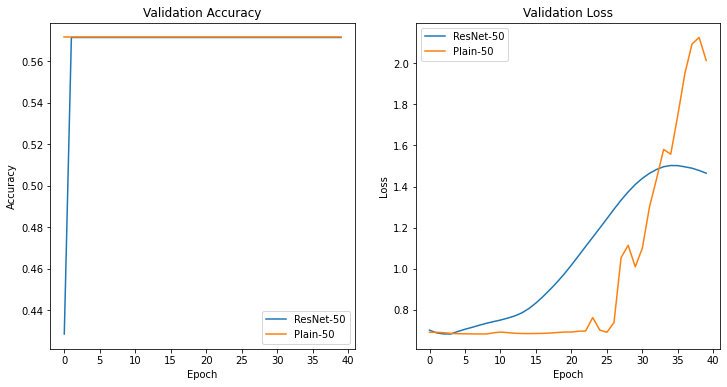

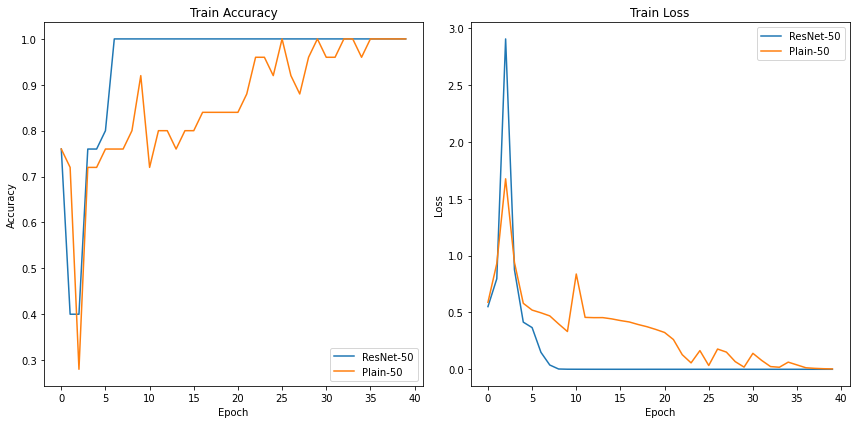

In [17]:
import matplotlib.pyplot as plt
# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# validation 데이터 정확도
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# validation 로스
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# 
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Train 데이터 정확도
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Train 로스
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

plt.tight_layout()

plt.show()

###  Beans Dataset

In [18]:
import urllib3
import tensorflow_datasets as tfds

urllib3.disable_warnings()

# Load the tf_flowers dataset
dataset_name = 'beans'
train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

# Preprocess the images and create batches
batch_size = 32
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
    image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet-50
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.map(preprocess_image)
validation_dataset = validation_dataset.batch(batch_size)
input_shape = (224, 224, 3)
num_classes = 3

In [20]:
resnet_34 = build_resnet(input_shape, False, num_classes, True)
plain_34 = build_plainnet(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_plainnet(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
26/26 [==============================] - 11s 257ms/step - loss: 1.5058 - accuracy: 0.5490 - val_loss: 148968.4531 - val_accuracy: 0.3333
Epoch 2/40
26/26 [==============================] - 5s 183ms/step - loss: 0.7750 - accuracy: 0.6723 - val_loss: 11963.3818 - val_accuracy: 0.3720
Epoch 3/40
26/26 [==============================] - 5s 183ms/step - loss: 0.7521 - accuracy: 0.7110 - val_loss: 135.1242 - val_accuracy: 0.3913
Epoch 4/40
26/26 [==============================] - 5s 183ms/step - loss: 0.7064 - accuracy: 0.7134 - val_loss: 52.3269 - val_accuracy: 0.3382
Epoch 5/40
26/26 [==============================] - 5s 183ms/step - loss: 0.6780 - accuracy: 0.7352 - val_loss: 9.6389 - val_accuracy: 0.4493
Epoch 6/40
26/26 [==============================] - 5s 184ms/step - loss: 0.6121 - accuracy: 0.7557 - val_loss: 1.7189 - val_accuracy: 0.5604
Epoch 7/40
26/26 [==============================] - 5s 185ms/step - loss: 0.5619 - accuracy: 0.7836 - val_loss: 1.0844 - val_accuracy: 

In [23]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
26/26 [==============================] - 17s 425ms/step - loss: 1.6321 - accuracy: 0.5067 - val_loss: 71.0127 - val_accuracy: 0.3430
Epoch 2/40
26/26 [==============================] - 9s 337ms/step - loss: 0.8242 - accuracy: 0.6771 - val_loss: 34.2746 - val_accuracy: 0.3865
Epoch 3/40
26/26 [==============================] - 9s 339ms/step - loss: 0.7479 - accuracy: 0.7219 - val_loss: 1.6798 - val_accuracy: 0.5797
Epoch 4/40
26/26 [==============================] - 9s 338ms/step - loss: 0.6993 - accuracy: 0.7255 - val_loss: 1.0074 - val_accuracy: 0.5604
Epoch 5/40
26/26 [==============================] - 9s 339ms/step - loss: 0.6540 - accuracy: 0.7654 - val_loss: 1.4816 - val_accuracy: 0.6087
Epoch 6/40
26/26 [==============================] - 9s 337ms/step - loss: 0.6288 - accuracy: 0.7594 - val_loss: 0.9209 - val_accuracy: 0.5894
Epoch 7/40
26/26 [==============================] - 9s 335ms/step - loss: 0.5340 - accuracy: 0.7811 - val_loss: 1.1290 - val_accuracy: 0.6570
Epo

In [24]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
26/26 [==============================] - 8s 192ms/step - loss: 1.3577 - accuracy: 0.4027 - val_loss: 230869840.0000 - val_accuracy: 0.3720
Epoch 2/40
26/26 [==============================] - 4s 171ms/step - loss: 1.0659 - accuracy: 0.3785 - val_loss: 6114079.0000 - val_accuracy: 0.3478
Epoch 3/40
26/26 [==============================] - 4s 170ms/step - loss: 1.0816 - accuracy: 0.3507 - val_loss: 30845.5215 - val_accuracy: 0.3382
Epoch 4/40
26/26 [==============================] - 4s 171ms/step - loss: 1.0766 - accuracy: 0.3591 - val_loss: 2467.7478 - val_accuracy: 0.3527
Epoch 5/40
26/26 [==============================] - 5s 172ms/step - loss: 1.0613 - accuracy: 0.3748 - val_loss: 558.9895 - val_accuracy: 0.3913
Epoch 6/40
26/26 [==============================] - 4s 172ms/step - loss: 1.0459 - accuracy: 0.3918 - val_loss: 46.1471 - val_accuracy: 0.3430
Epoch 7/40
26/26 [==============================] - 4s 172ms/step - loss: 1.0308 - accuracy: 0.3857 - val_loss: 16.0721 - va

In [25]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=40)

Epoch 1/40
26/26 [==============================] - 11s 296ms/step - loss: 1.3134 - accuracy: 0.3229 - val_loss: 1.0991 - val_accuracy: 0.3188
Epoch 2/40
26/26 [==============================] - 7s 268ms/step - loss: 1.1444 - accuracy: 0.3495 - val_loss: 1.1306 - val_accuracy: 0.3188
Epoch 3/40
26/26 [==============================] - 7s 269ms/step - loss: 1.1440 - accuracy: 0.3555 - val_loss: 1.1817 - val_accuracy: 0.3188
Epoch 4/40
26/26 [==============================] - 7s 270ms/step - loss: 1.0857 - accuracy: 0.3809 - val_loss: 1.4254 - val_accuracy: 0.3188
Epoch 5/40
26/26 [==============================] - 7s 271ms/step - loss: 1.0640 - accuracy: 0.4002 - val_loss: 1.5089 - val_accuracy: 0.3188
Epoch 6/40
26/26 [==============================] - 7s 273ms/step - loss: 1.0383 - accuracy: 0.4377 - val_loss: 1.8496 - val_accuracy: 0.3188
Epoch 7/40
26/26 [==============================] - 7s 272ms/step - loss: 1.0286 - accuracy: 0.4534 - val_loss: 1.1800 - val_accuracy: 0.3478
Epoch

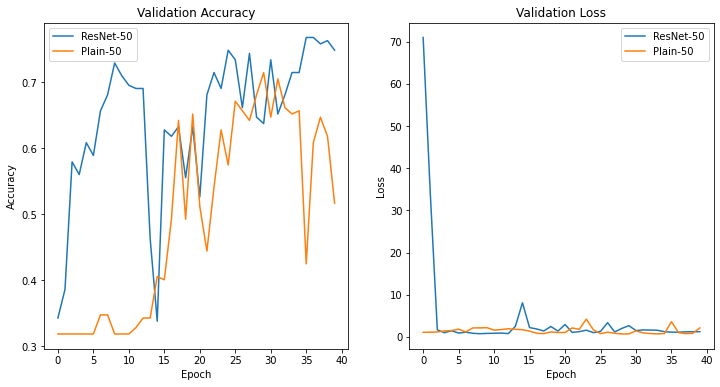

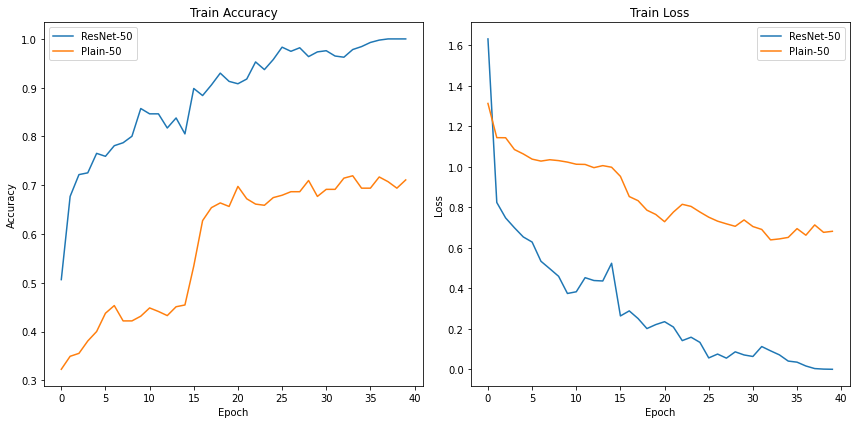

In [26]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

plt.tight_layout()

plt.show()

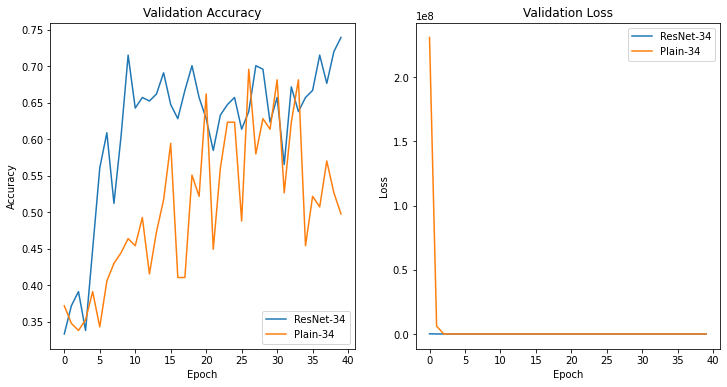

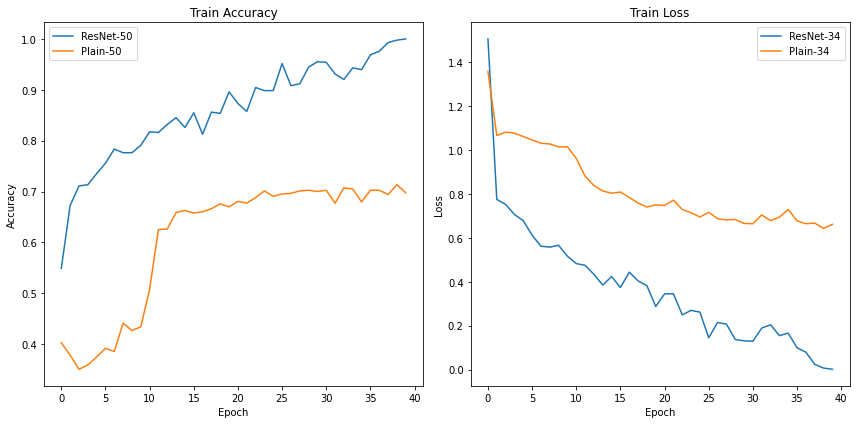

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

plt.tight_layout()

plt.show()